In [30]:
# Imports here
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

# Import 
import json
import os
from collections import OrderedDict
import pandas as pd
import random
import torch
import torchvision
from torch import nn
import numpy as np

from torchvision import transforms, models
from torchvision.datasets import ImageFolder

In [31]:
data_dir = '/notebooks/flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'
#!unzip /flowers.zip

In [56]:
# TODO: Define your transforms for the training, validation, and testing sets
#data_transforms =
train_dir_transforms = transforms.Compose([transforms.RandomResizedCrop(224), # before all 225 ##256
                                           transforms.RandomHorizontalFlip(),
                                           transforms.ToTensor(),
                                           transforms.Normalize([0.485, 0.456, 0.406],
                                                                [0.229, 0.224, 0.225])])
valid_dir_transforms = transforms.Compose([transforms.Resize(224),
                                           transforms.CenterCrop(224),
                                           transforms.ToTensor(),
                                           transforms.Normalize([0.485, 0.456, 0.406],
                                                                [0.229, 0.224, 0.225])])
test_dir_transforms = transforms.Compose([transforms.Resize(224),
                                          transforms.CenterCrop(224),
                                          transforms.ToTensor(),
                                          transforms.Normalize([0.485, 0.456, 0.406],
                                                               [0.229, 0.224, 0.225])])

# TODO: Load the datasets with ImageFolder
#image_datasets = 
train_data = ImageFolder(train_dir, train_dir_transforms)
valid_set = ImageFolder(valid_dir, valid_dir_transforms)
test_set = ImageFolder(test_dir, test_dir_transforms)

# TODO: Using the image datasets and the trainforms, define the dataloaders
#dataloaders = 
trainloader = torch.utils.data.DataLoader(train_data, batch_size =512, shuffle=True)
valid_data = torch.utils.data.DataLoader(valid_set, batch_size=512)
test_data = torch.utils.data.DataLoader(test_set, batch_size=512)

classes = dict(zip(list(range(len(train_data.classes))),train_data.classes))

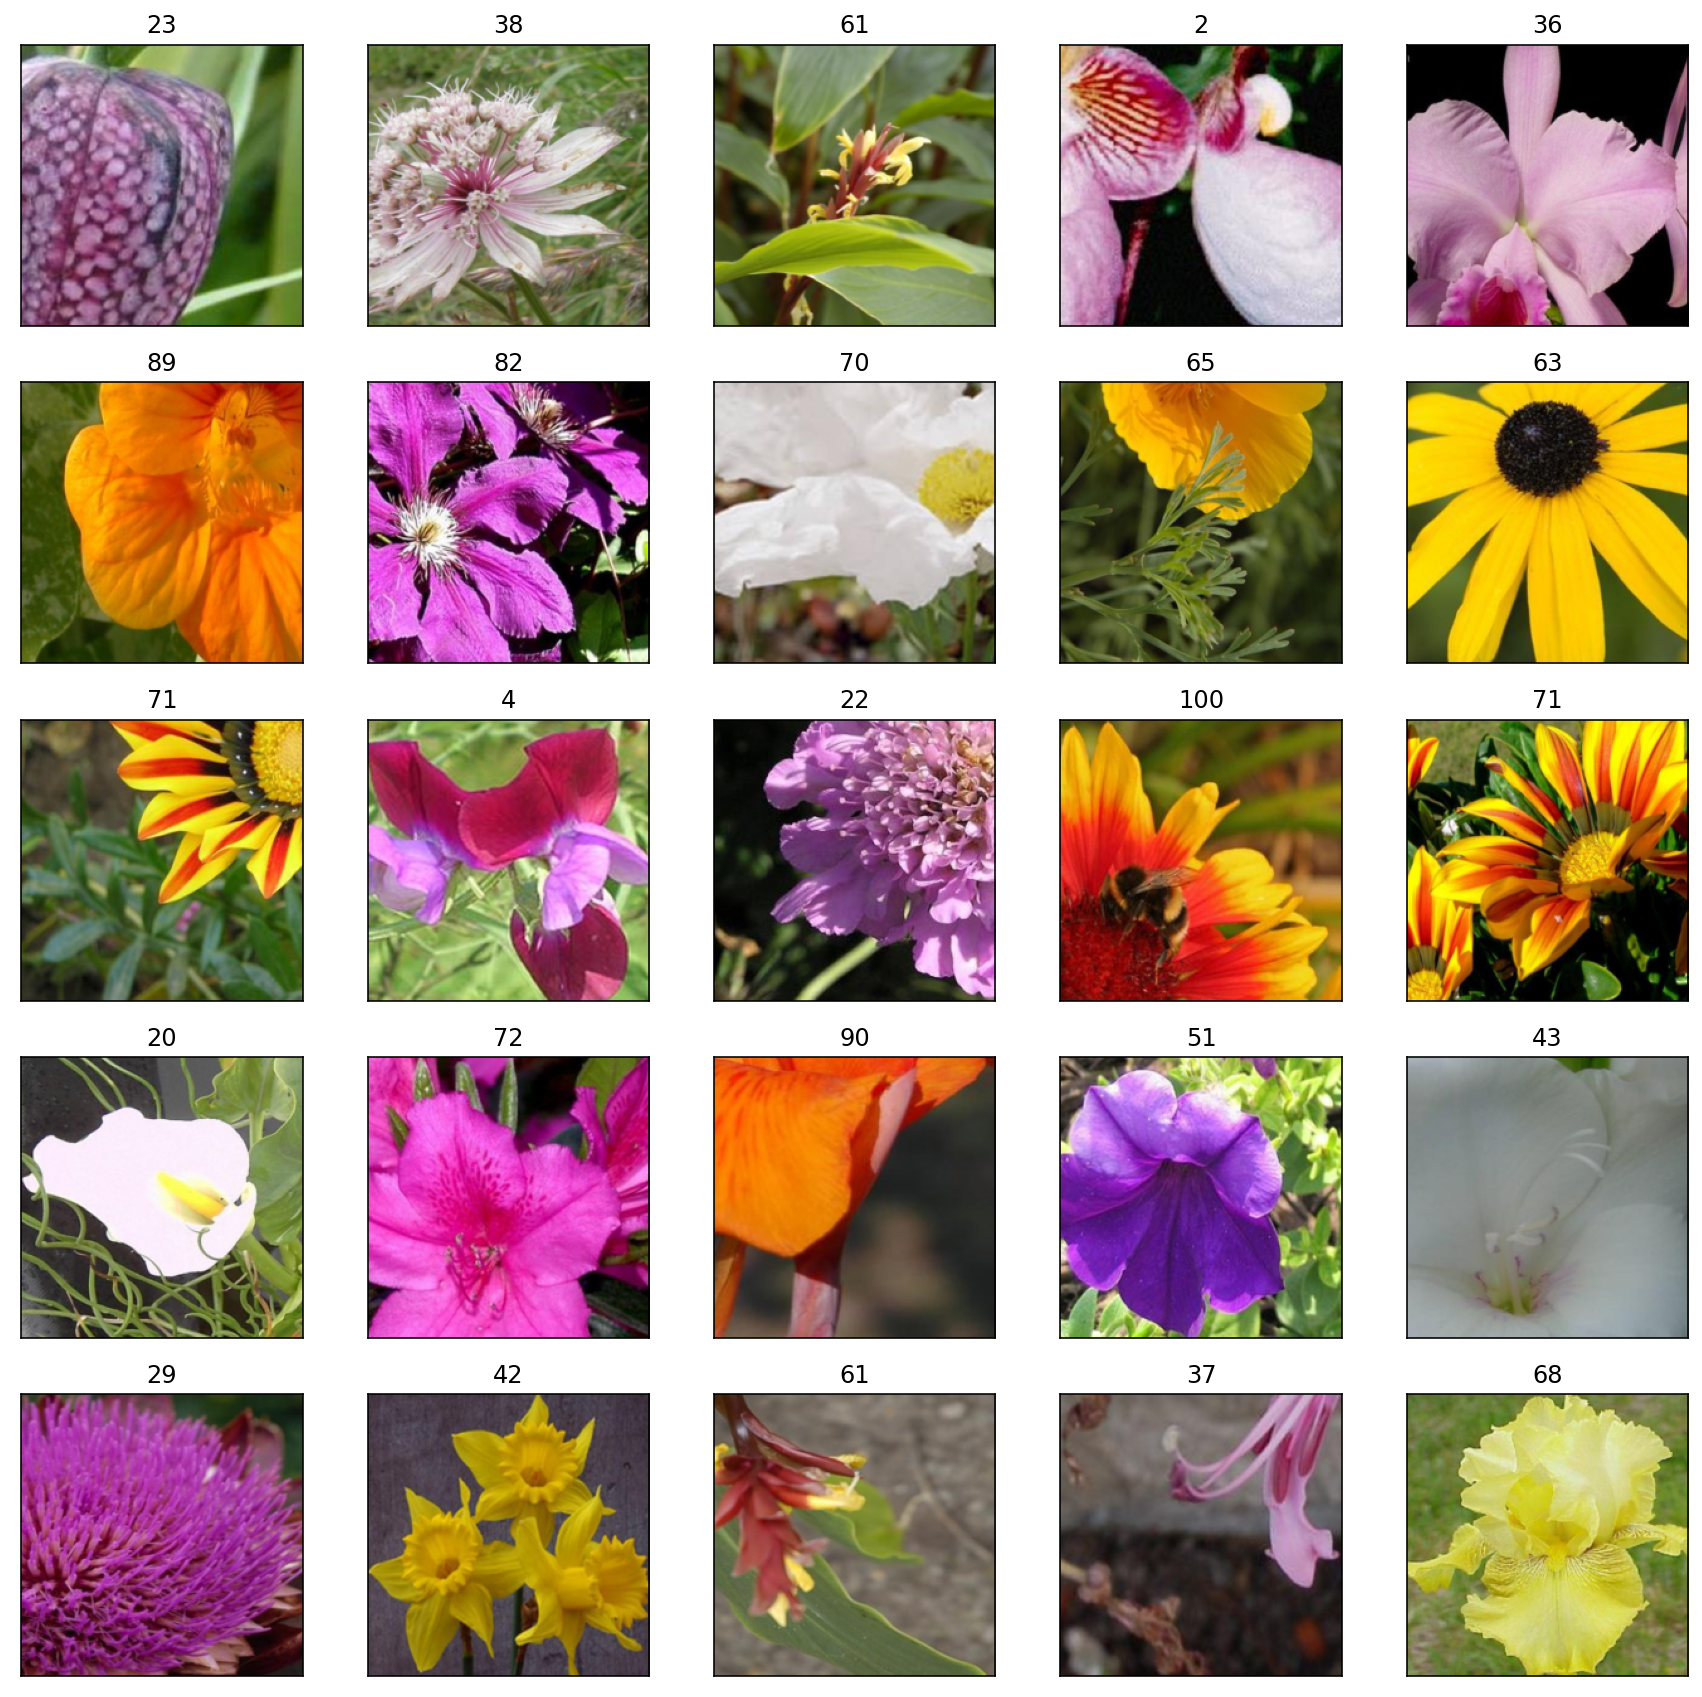

In [33]:
def denormalise(image):
  try:
    image = image.cpu().numpy().transpose(1, 2, 0)
  except:
    image = image.transpose(1, 2, 0) # PIL images have channel last
  mean = [0.485, 0.456, 0.406]
  stdd = [0.229, 0.224, 0.225]
  image = (image * stdd + mean).clip(0, 1)
  return image
  
dataiter = iter(trainloader)
images, labels = dataiter.next()
images = images.numpy()
fig = plt.figure(figsize=(15,15))

for idx in np.arange(25):
  ax = fig.add_subplot(5, 5, idx+1, xticks=[], yticks=[])
  ax.imshow(denormalise(images[idx]), cmap='gray')
  ax.set_title(classes[labels[idx].item()])

In [42]:
with open('./cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

In [43]:
# TODO: Build and train your network
model = models.vgg16(weights='DEFAULT')
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [44]:
#freeze parameters
for param in model.parameters():
    param.requires_grad = False 

#new classifier for the feedforward
classifier = nn.Sequential(OrderedDict([
                            ('fc1', nn.Linear(25088, 320)), #4608,320
                            ('relu', nn.ReLU()),
                            ('dropout', nn.Dropout(0.5)),
                            ('fc2', nn.Linear(320, 300)), #320,300
                            ('relu', nn.ReLU()),
                            ('dropout', nn.Dropout(0.5)),
                            ('fc3', nn.Linear(300, 102)), #300,102
                            ('output', nn.LogSoftmax(dim=1))
                            ]))
model.classifier = classifier
print(model)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [45]:
def validation(model, valid_data, criterion):
    test_loss = 0
    accuracy = 0
    for images, labels in valid_data:
        
        images,labels = images.to('cuda'), labels.to('cuda')
        
        output = model.forward(images)
        batch_loss = criterion(output, labels)
        test_loss += batch_loss.item()
        
        ps = torch.exp(output)
        equality = (labels.data == ps.max(dim=1)[1])
        accuracy += equality.type(torch.FloatTensor).mean()
    
    return test_loss, accuracy

In [46]:
train_losses, valid_losses,valid_acc = [], [], []

In [ ]:
learning_rate=0.000005
#0.00005
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.functional.nll_loss
epochs = 50
#running_loss = 0
model.to('cuda')
for epoch in range(epochs):
  model.train()
  counter = 0
  for data in trainloader:
    X , y= data
    X , y = X.to('cuda'), y.to('cuda')
    optimizer.zero_grad() # clear gradient information.
    #output = model(X) <- gives errors
    output = model.forward(X)
    loss = criterion(output, y)
    loss.backward() # do pack-propagation step
    optimizer.step() # tell optimizer that you finished batch/iteration.
    counter += 1
    #running_loss += loss.item()
 
 
  # network in eval mode for inference
  model.eval()
            
  # Turn off gradients for validation, saves memory and computations
  with torch.no_grad():
      test_loss, accuracy = validation(model, valid_data, criterion)
  print("Epoch: {}/{}...".format(epoch+1,epochs),
        "Loss: {:.4f}".format(loss.data),
        "Train Loss: {:.3f}.. ".format(test_loss/len(valid_data)),
        "Train Accuracy: {:.3f}".format(accuracy/len(valid_data)))

  train_losses.append(loss.data)
  valid_losses.append(test_loss/len(valid_data))
  valid_acc.append(accuracy/len(valid_data))
  running_loss = 0
  model.train()

Epoch: 1/50... Loss: 0.2191 Train Loss: 0.268..  Train Accuracy: 0.949
Epoch: 2/50... Loss: 0.2770 Train Loss: 0.268..  Train Accuracy: 0.948
Epoch: 3/50... Loss: 0.2285 Train Loss: 0.269..  Train Accuracy: 0.948


In [ ]:
torch.save(model,'models/cnn/checkpoint_epoch_'+str(len(valid_losses))+'_lr_'+str(learning_rate)+'.pth')

# Print loss
cpu_train_losses = []
cpu_valid_losses = []
cpu_valid_acc = []

for tens in train_losses:
    cpu_train_losses.append(tens.to('cpu'))
plt.plot(cpu_train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.legend(frameon=False)
plt.savefig('fig/plot_loss_epoch_'+str(len(valid_losses))+'_lr_'+str(learning_rate)+'.jpg')

plt.clf()
# Plotting the graph for Validation accuracy wrt Steps
plt.plot(valid_acc, label='Validation Accuracy')
plt.legend(frameon=False)
plt.savefig('fig/plot_acc_epoch_'+str(len(valid_losses))+'_lr_'+str(learning_rate)+'.jpg')

In [57]:
correct = 0
total = 0
with torch.no_grad():
    for images,labels in test_data:
        model.to('cpu')
        #images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test_data set: %d %%' % (100 * correct / total))

Accuracy of the network on the test_data set: 88 %


In [46]:
# Evaluate the trained network.
total = 0
correct = 0
with torch.no_grad():   # No need for keepnig track of necessary changes to the gradient.
  for X,y in test_data:
    X , y = X.to('cuda'), y.to('cuda')
    output = model(X)
    for idx, val in enumerate(output):
      if torch.argmax(val) == y[idx]:
        correct += 1
      total += 1
  print('Accuracy:', round(correct/total, 3))

Accuracy: 0.902


In [47]:
torch.save(model,'checkpoint_902.pth')